In [38]:
import pandas
import numpy

import matplotlib.pyplot as plt

from scipy import stats


In [39]:
# We load the data from the URL and and filter out the unnecessary columns
df = pandas.read_csv(
    "https://course-resources.minerva.edu/uploaded_files/mu/00294347-0809/sf-sea-level-rise-sample.csv",
)[["NonWhite", "Education"]]

# We create or first subset of data with white-majority populations per 
# census blockgroup
white = df[df["NonWhite"] < 0.5]
white_education = white["Education"]

# We create our second subset of data with non-white-majority populations per
# census blockgroup
non_white = df[df["NonWhite"] >= 0.5]
non_white_education = non_white["Education"]


In [40]:
# Print mean, standard deviation, and max and min values for both subsets
print("Whole dataset")
print(df.describe())


Whole dataset
        NonWhite  Education
count  60.000000  60.000000
mean    0.589638   0.857605
std     0.204536   0.109820
min     0.128998   0.539999
25%     0.481250   0.804000
50%     0.569000   0.888000
75%     0.742500   0.937197
max     0.981262   1.000996


In [41]:
# Print mean, standard deviation, and max and min values for the white subset
print("White")
print(white.describe())


White
        NonWhite  Education
count  20.000000  20.000000
mean    0.367761   0.945674
std     0.115575   0.041436
min     0.128998   0.853000
25%     0.290750   0.918500
50%     0.398580   0.960585
75%     0.463750   0.974000
max     0.494667   1.000996


In [42]:
# Print mean, standard deviation, and max and min values for the non-white subset
print("Non-white")
print(non_white.describe())


Non-white
        NonWhite  Education
count  40.000000  40.000000
mean    0.700577   0.813570
std     0.137522   0.106969
min     0.511000   0.539999
25%     0.571000   0.771499
50%     0.682500   0.824004
75%     0.799250   0.896998
max     0.981262   0.942001


In [43]:
# Compute the non-white median for the whole dataset
print(f"NonWhite median, Education median for whole dataset")
print(df["NonWhite"].median(), df["Education"].median())


NonWhite median, Education median for whole dataset
0.569 0.8879999999999999


In [44]:
# Compute the non-white median for the white subset
print(f"NonWhite median, Education median for white")
print(white["NonWhite"].median(), white_education.median())


NonWhite median, Education median for white
0.39857999999999993 0.960584645


In [45]:
# Compute the non-white median for the non-white subset
print(f"NonWhite median, Education median for black")
print(non_white["NonWhite"].median(), non_white_education.median())


NonWhite median, Education median for black
0.6825005 0.824004425


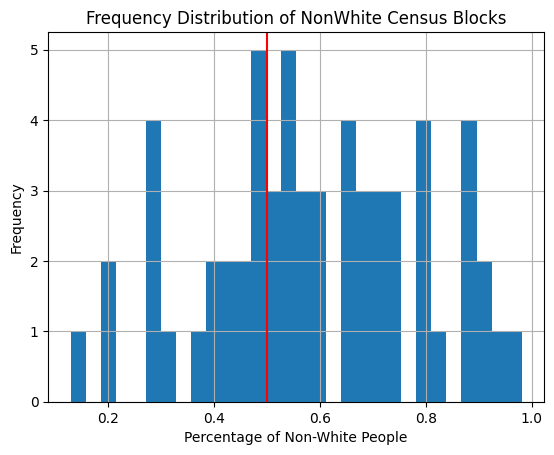

In [46]:
# Creates a frequency distribution of non-white proportion across the sample census blocks
df.hist(column="NonWhite", bins=30)

# Draws the line between white-majority blocks (> 50% white) and white-minority blocks (<50%)
plt.axvline(0.5, color="r")
plt.title("Frequency Distribution of NonWhite Census Blocks")
plt.xlabel("Percentage of Non-White People")
plt.ylabel("Frequency")
plt.show()


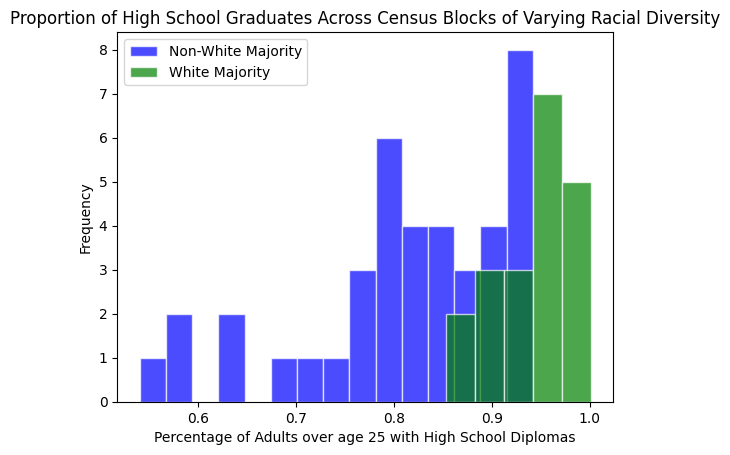

In [47]:
# This is a computation to determine the number of bins to use for the histogram, so that
# the bins are of equal width
bins = 15
w_range = max(white["Education"]) - min(white["Education"])
nw_range = max(non_white["Education"]) - min(non_white["Education"])
max_range = max(w_range, nw_range)
space_per_bin = max_range / bins
w_bins = int(w_range / space_per_bin)
nw_bins = int(nw_range / space_per_bin)

plt.hist(non_white["Education"], edgecolor = "white", color = "blue", label = "Non-White Majority", alpha = 0.7, bins = nw_bins)
plt.hist(white["Education"], edgecolor = "white", color = "green", label = "White Majority", alpha = 0.7, bins = w_bins)
plt.xlabel("Percentage of Adults over age 25 with High School Diplomas")
plt.ylabel("Frequency")
plt.title("Proportion of High School Graduates Across Census Blocks of Varying Racial Diversity")
plt.legend()
plt.show()

In [48]:
def difference_of_means_test(control, treatment, tails=1):
    n_1, n_2 = len(control), len(treatment)
    x_1, x_2 = numpy.mean(control), numpy.mean(treatment)

    # sample SD formula (aka Bessel’s correction): use n-1 in denominator
    s_1, s_2 = numpy.std(control, ddof=1), numpy.std(treatment, ddof=1)

    # conservative estimate from OpenIntro
    DOF = min(n_1, n_2) - 1

    SE = numpy.sqrt(s_1**2 / n_1 + s_2**2 / n_2)
    t_score = numpy.abs((x_2 - x_1)) / SE
    p_value = tails * stats.t.cdf(-t_score, DOF)

    # OpenIntro section 5.3.6
    pooled_SD = numpy.sqrt(
        (s_1**2 * (n_1 - 1) + s_2**2 * (n_2 - 1)) / (n_1 + n_2 - 2)
    )
    cohen_d = (x_2 - x_1) / pooled_SD

    return p_value, cohen_d


# this function creates an upper and lower bound for a confidence interval
def confidence_interval(point_estimate, SE, conf_level):
    z = stats.norm.ppf(
        1 - (1 - conf_level) / 2
    )  # gives 1.96 for a 95% confidence level
    lowbound = point_estimate - z * SE
    highbound = point_estimate + z * SE
    return lowbound, highbound


In [49]:
p_value, cohen_d = difference_of_means_test(
    white_education, non_white_education, tails=2
)
print(f"p-value: {p_value}, Cohen's d: {cohen_d}")


p-value: 1.5483509410856891e-06, Cohen's d: -1.4538461053727096


In [50]:
# Computes the 95% confidence interval for the whole dataset
print(
    f'Whole: CI 95%: {confidence_interval(numpy.mean(df["Education"]), numpy.std(df["Education"]) / numpy.sqrt(len(df)), 0.95)}'
)


Whole: CI 95%: (0.830049436239439, 0.8851597997605609)


In [51]:
# Computes the 95% confidence interval for the white subset
print(
    f"White: CI 95%: {confidence_interval(numpy.mean(white_education), numpy.std(white_education) / numpy.sqrt(len(white)), 0.95)}"
)


White: CI 95%: (0.9279739670008129, 0.9633739369991869)


In [52]:
# Computes the 95% confidence interval for the non-white subset
print(
    f"Non-white: CI 95%: {confidence_interval(numpy.mean(non_white_education), numpy.std(non_white_education) / numpy.sqrt(len(non_white)), 0.95)}"
)


Non-white: CI 95%: (0.7808374499392452, 0.8463024520607545)
